<a href="https://colab.research.google.com/github/TruongGiangVu/VGG16_RNN_LSTM_SignLanguageRecognition/blob/main/VGG16_RNN_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# common library 
import numpy as np
import os
import time
import cv2
import matplotlib.pyplot as plt
# import glob
from google.colab.patches import cv2_imshow

# tensorflow library
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, SimpleRNN, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D, MaxPooling2D
# from keras.layers import TimeDistributed, GRU, Dense, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

from keras.applications.vgg16 import VGG16

# reading data
import csv
import threading

# Label encoder
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [ ]:
# change path
import os
os.chdir('/content/drive/MyDrive/VSLProject')
print(os.getcwd())

/content/drive/MyDrive/VSLProject


# Global params

In [ ]:
# some global params
SIZE = (64, 64) 

# SIZE = (224, 224) 
CHANNELS = 3
NBFRAME = 10
BS = 20

NUM_THREADS = 8

#preprocessing
LENGTH_TRIM = 130
classes_file = 'classes.npy'

# Functions

## Preprocessing

In [ ]:
# resize image by dsize = (128, 128)
def resizeImage(img, dsize):
  sizeImg = (img.shape[0],img.shape[1])
  if sizeImg != dsize and dsize != (None, None):
    img = cv2.resize(img,dsize)
  return img

# remove left right background
def removeTrimBackground(img, length = 120):
  img = img[:,length:-1*length]
  return img

def resizeScale(img, scale = 30):
  scale_percent = scale # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)
    
  # resize image
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  return resized

In [ ]:
def preprocessingImg(img, dsize = (128,128)):
  # img = human_detection(img)
  img = removeTrimBackground(img, LENGTH_TRIM)
  img = resizeImage(img, dsize)
  return img

## Reading data, Encode

In [ ]:
def readFramesThread(sema, x_data, y_data, word, path, dsize):
  sema.acquire()
    
  frames = os.listdir(path)
  lframes = []
  
  for frame in frames: # read all frames in video
    frame_path = os.path.join(path, frame)
    img = cv2.imread(frame_path, 1)
    img = preprocessingImg(img, dsize)
    lframes.append(img)

  x_data.append(lframes) # add video into list
  y_data.append(word) # add label

  # time.sleep(0.2)
  sema.release()


def readDataThread(input_path, csv_file, dsize=(128,128), listWord = None):
  x_data = []
  y_data = []

  maxthreads = NUM_THREADS
  sema = threading.Semaphore(value=maxthreads) # sema type
  threads = list()

  with open(csv_file) as csvfile: # read path from csv
    reader = csv.reader(csvfile)
    for row in reader:
      # video path
      video = row[0]
      word = video.split('/')[0]

      if (listWord != None) and (word not in listWord): # decrease num classes
        continue

      # print(video)
      path = os.path.join(input_path, video)
      # execute thread
      thread = threading.Thread( target=readFramesThread, args=(sema, x_data, y_data, word, path, dsize) ) 
      threads.append(thread)
      thread.start()
    
    for t in threads: # for waiting all thread end 
      t.join()

  return x_data, y_data


In [ ]:
def readFrames(path, dsize):
  frames = os.listdir(path)
  lframes = []
  
  for frame in frames: # read all frames in video
    frame_path = os.path.join(path, frame)
    img = cv2.imread(frame_path, 1)
    img = resizeImage(img, dsize)
    lframes.append(img)

  return lframes

def readData(input_path, csv_file, dsize=(128,128), listWord = None):
  x_data = []
  y_data = []

  with open(csv_file) as csvfile: # read path from csv
    reader = csv.reader(csvfile)
    for row in reader:
      # video path
      video = row[0]
      word = video.split('/')[0]
      # if (listWord != None) and (word not in listWord): # decrease num classes
      #   continue

      print(video)
      path = os.path.join(input_path, video)
      lframes = readFrames(path, dszie)
      
      x_data.append(lframes) # add video into list
      y_data.append(word) # add label

  return x_data, y_data

In [ ]:
#encoder label to train in model
def encoderLabel(y_train, y_test, classes_file = 'classes.npy', save = True):
  encoder = LabelEncoder()
  encoder.fit(y_train)

  # save classes, save as numpy array
  if save == True:
    np.save(classes_file, encoder.classes_)

  # encoder to number
  y_train1 = encoder.fit_transform(y_train)
  y_test1 = encoder.fit_transform(y_test)

  num_classes=len(np.unique(y_train))
  #encoder to binary matrix
  y_train2 = np_utils.to_categorical(y_train1, num_classes=len(np.unique(y_train)))
  y_test2 = np_utils.to_categorical(y_test1, num_classes=len(np.unique(y_test)))
  return y_train2, y_test2, num_classes

# Main

In [ ]:
# listWord = ['Argentina', 'Accept' , 'Birthday', 'Candy', 'Dance','Help','Last name', 'Food', 'Red','Enemy']

## Read data and preprocess

In [ ]:
# prepare train data
start = time.time()

train_path = 'Datasets/lsa64_videoperfolder/train'
train_csv = 'Datasets/lsa64_videoperfolder/train_2.csv'

# x_train, y_train = readData(test_path, test_csv, SIZE)
# x_train_o, y_train_o = readDataThread(train_path, train_csv, SIZE, listWord)
x_train_o, y_train_o = readDataThread(train_path, train_csv, SIZE)

end = time.time()
print('time:', end - start)

time: 1686.3207535743713


In [ ]:
# prepare test data
start = time.time()

test_path = 'Datasets/lsa64_videoperfolder/train'
test_csv = 'Datasets/lsa64_videoperfolder/val_2.csv'

# x_test_o, y_test_o = readDataThread(test_path, test_csv, SIZE, listWord)
x_test_o, y_test_o = readDataThread(test_path, test_csv, SIZE)

end = time.time()
print('time:', end - start)

time: 528.0885164737701


In [ ]:
# convert to numpy array
x_train = np.array(x_train_o)
y_train = np.array(y_train_o)
x_test = np.array(x_test_o)
y_test = np.array(y_test_o)

print('x_train shape', x_train.shape) # (400, 10, 128, 128, 3) max 2560
print('y_train shape', y_train.shape) # (400,)
print('x_test shape', x_test.shape) # (100, 10, 128, 128, 3) max 640
print('y_test shape', y_test.shape) # (100,)

convert = False
if convert == True:
  n, nb, h, w, c = x_train.shape
  x_train= x_train.reshape(n, nb, h*w*c)
  n, nb, h, w, c = x_test.shape
  x_test= x_test.reshape(n, nb, h*w*c)

  print('x_train shape', x_train.shape) # (400, 10, 223) max 2560
  print('y_train shape', y_train.shape) # (400,)
  print('x_test shape', x_test.shape) # (100, 10, 128, 128, 3) max 640
  print('y_test shape', y_test.shape) # (100,)

x_train shape (1920, 10, 64, 64, 3)
y_train shape (1920,)
x_test shape (640, 10, 64, 64, 3)
y_test shape (640,)


In [ ]:
x_train = x_train /255.
x_test = x_test / 255.

## Encode label

In [ ]:
# show num classes, it is neccesảy to run
listclasses =  np.unique(y_train)
num_classes = len(listclasses)
print(num_classes)
print(listclasses)
# encode label for training
y_train_decode, y_test_decode, num_classes = encoderLabel(y_train, y_test)
# y_train_decode, y_test_decode are var which encode for training
# y_train, y_test are original var to test after that, for showing word from predicted video 
print(y_train_decode.shape)
print(y_test_decode.shape)

64
['Accept' 'Appear' 'Argentina' 'Away' 'Barbecue' 'Bathe' 'Birthday'
 'Bitter' 'Born' 'Breakfast' 'Bright' 'Buy' 'Call' 'Candy' 'Catch'
 'Chewing-gum' 'Coin' 'Colors' 'Copy' 'Country' 'Dance' 'Deaf' 'Drawer'
 'Enemy' 'Find' 'Food' 'Give' 'Green' 'Help' 'Hungry' 'Last name' 'Learn'
 'Light-blue' 'Man' 'Map' 'Milk' 'Mock' 'Music' 'Name' 'None' 'Opaque'
 'Patience' 'Perfume' 'Photo' 'Realize' 'Red' 'Red_2' 'Rice' 'Run' 'Ship'
 'Shut down' 'Skimmer' 'Son' 'Spaghetti' 'Sweet milk' 'Thanks' 'To land'
 'Trap' 'Uruguay' 'Water' 'Where' 'Women' 'Yellow' 'Yogurt']
(1920, 64)
(640, 64)


# Model

## Model Architecture

In [ ]:
def load_VGG16_model(shape=(112, 112, 3)):
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=shape)
  print("Model loaded..!")
  base_model.summary()

  # model.add(Flatten())
  output1 = GlobalMaxPool2D()
  output2 = Flatten()
  module = keras.Sequential([base_model, output1, output2])
  module.summary()
  return module

def RNNModel(shape=(5, 112, 112, 3), nbout=3):
  model = Sequential()
  
  convnet = load_VGG16_model(shape[1:])
  model.add(TimeDistributed(convnet, input_shape=shape))

  model.add(SimpleRNN(256, dropout=0.2))
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(nbout, activation='softmax'))
  sgd = keras.optimizers.SGD(lr=0.00005, decay = 1e-6, momentum=0.9, nesterov=True)
  # sgd = keras.optimizers.SGD( momentum=0.9, nesterov=True)
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
#Create Model
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 112, 112, 3)
# INSHAPE= ( NBFRAME, SIZE[0] * SIZE[1] * CHANNELS)  # (5, 128 * 128 * 3)
print(INSHAPE) 
model = RNNModel(INSHAPE, num_classes)
model.summary()

(10, 64, 64, 3)
58892288/58889256 [==============================] - 0s 0us/step
Model loaded..!
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________

## Define model and run

In [ ]:
tic = time.time()

EPOCHS = 120
early_stoping = EarlyStopping(monitor='val_accuracy', patience=9, verbose=1, mode='max')
save_checkpoint = ModelCheckpoint('chkp/best-weights-RNN-10-5.hdf5', monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = True, mode='max')
csv_logger = CSVLogger('chkp/training-rnn.csv', separator=",", append=False) # dùng pandas đọc
# reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 1, min_lr = 1e-8, verbose=1)

callbacks = [early_stoping,  
             save_checkpoint,
             csv_logger,
            #  reduce_lr
             ]
# history = model.fit_generator(train,validation_data=valid,verbose=1,epochs=EPOCHS,callbacks=callbacks)
history = model.fit(x_train, y_train_decode, 
            epochs=EPOCHS, 
            batch_size=BS,
            shuffle=True,
            validation_data = (x_test, y_test_decode),
            verbose=1,
            callbacks=callbacks)

toc = time.time()
print("TRAINING TIME: ", toc-tic)

Epoch 1/120
96/96 [==============================] - 89s 518ms/step - loss: 4.3132 - accuracy: 0.0149 - val_loss: 4.1679 - val_accuracy: 0.0188

Epoch 00001: val_accuracy improved from -inf to 0.01875, saving model to chkp/best-weights-RNN-10-5.hdf5
Epoch 2/120
96/96 [==============================] - 48s 504ms/step - loss: 4.2361 - accuracy: 0.0195 - val_loss: 4.0992 - val_accuracy: 0.0437

Epoch 00002: val_accuracy improved from 0.01875 to 0.04375, saving model to chkp/best-weights-RNN-10-5.hdf5
Epoch 3/120
96/96 [==============================] - 48s 504ms/step - loss: 4.1974 - accuracy: 0.0235 - val_loss: 4.0367 - val_accuracy: 0.0672

Epoch 00003: val_accuracy improved from 0.04375 to 0.06719, saving model to chkp/best-weights-RNN-10-5.hdf5
Epoch 4/120
96/96 [==============================] - 48s 504ms/step - loss: 4.1392 - accuracy: 0.0352 - val_loss: 3.9593 - val_accuracy: 0.0734

Epoch 00004: val_accuracy improved from 0.06719 to 0.07344, saving model to chkp/best-weights-RNN-1

## History running

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Uninstalling matplotlib-3.3.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.3.2-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.3.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.3.2
     |████████████████████████████████| 13.1MB 234kB/s 
ERROR: imageai 2.1.6 has requirement matplotlib==3.3.2, but you'll have matplotlib 3.1.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


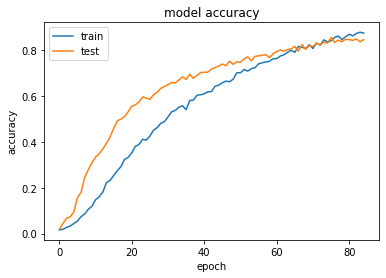

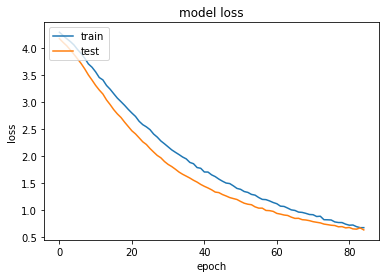

In [ ]:
# !python -m pip uninstall matplotlib
# !pip install matplotlib==3.1.3
import pandas as pd
import matplotlib.pyplot as plt
his = pd.read_csv('chkp/training-rnn.csv')  
plt.plot(his['accuracy'])
plt.plot(his['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print()
# summarize history for loss
plt.plot(his['loss'])
plt.plot(his['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# References
[1] face recognition code from NCKH: https://colab.research.google.com/drive/1I67IhZfni2sOlV36N6LqqIqf-S0KhACz

[2] Model LSTM Giang: https://colab.research.google.com/drive/1_92N1vbv3fRBEguGeJrPSqGdGVVp5D0v

[3] github retinanet: https://github.com/fizyr/keras-retinanet

[4] ImageAI for Object detection: https://imageai.readthedocs.io/en/latest/detection/

[5] Video Classification CNN and LSTM: https://github.com/sagarvegad/Video-Classification-CNN-and-LSTM-